In [1]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
)

from monai.config import print_config
from monai.metrics import DiceMetric, MeanIoU
from monai.networks.nets import UNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)


import torch

plt.rcParams['axes.titlesize'] = 'small'

directory = "datasets/processed"
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

datasets/processed


In [2]:
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        # ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
        # CropForegroundd(keys=["image", "label"], source_key="image"),
    ]
)

In [3]:
data_dir = "datasets/"
split_json = "dataset_0.json"

datasets = data_dir + split_json
val_files = load_decathlon_datalist(datasets, True, "validation")

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True)

Loading dataset:   0%|          | 0/6 [00:00<?, ?it/s]

Loading dataset: 100%|██████████| 6/6 [00:08<00:00,  1.43s/it]


image shape: torch.Size([1, 314, 314, 234]), label shape: torch.Size([1, 314, 314, 234])
Bounding box for label 6: [118, 185, 217, 250]


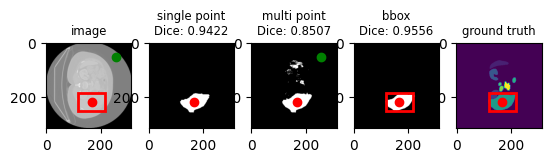

image shape: torch.Size([1, 255, 255, 276]), label shape: torch.Size([1, 255, 255, 276])
Bounding box for label 6: [80, 82, 185, 235]


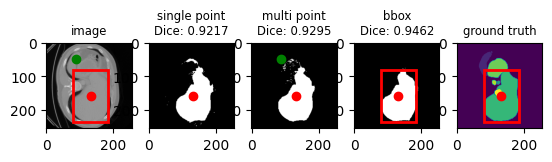

image shape: torch.Size([1, 241, 241, 246]), label shape: torch.Size([1, 241, 241, 246])
Bounding box for label 6: [75, 88, 190, 209]


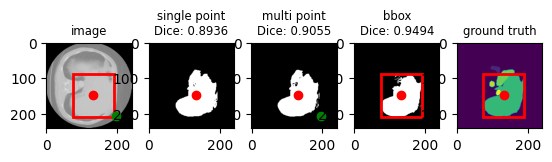

image shape: torch.Size([1, 334, 334, 248]), label shape: torch.Size([1, 334, 334, 248])
Bounding box for label 6: [110, 156, 249, 265]


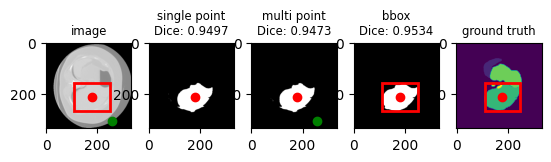

image shape: torch.Size([1, 333, 333, 224]), label shape: torch.Size([1, 333, 333, 224])
Bounding box for label 6: [135, 120, 219, 247]


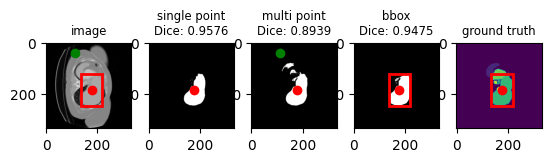

image shape: torch.Size([1, 254, 254, 292]), label shape: torch.Size([1, 254, 254, 292])
Bounding box for label 6: [76, 85, 161, 214]


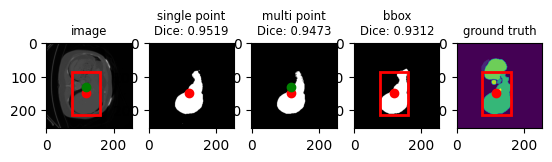

In [4]:
import numpy as np
import cv2

# 加载预训练的SAM模型
from segment_anything import SamPredictor, sam_model_registry

sam = sam_model_registry["vit_b"](checkpoint="checkpoints/sam_vit_b_01ec64.pth")
predictor = SamPredictor(sam)
predictor.model.to("cuda")
torch.set_grad_enabled(False)
# 准备评估指标
from monai.metrics import DiceMetric

dice_metric = DiceMetric(include_background=True, reduction="mean")
iou_metric = MeanIoU(include_background=True, reduction="mean")
slice_map = {
    "img0035.nii.gz": 170,
    "img0036.nii.gz": 230,
    "img0037.nii.gz": 204,
    "img0038.nii.gz": 204,
    "img0039.nii.gz": 204,
    "img0040.nii.gz": 180,
}

def find_max_contour(label_np):
    # Initialize max_area and max_label
    max_area = 0
    max_label = 0

    # Iterate over all labels
    for i in range(1, int(label_np.max()) + 1):  # start from 1 to exclude label 0
        area = np.sum(label_np == i)
        if area > max_area:
            max_area = area
            max_label = i

    # Find contours for max_label
    contours, _ = cv2.findContours(
        (label_np == max_label).astype(np.uint8), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE
    )

    # Initialize max_area and max_contour
    max_area = 0
    max_contour = None

    # Iterate over all contours
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > max_area:
            max_area = area
            max_contour = contour

    return max_contour, max_label


case_num = 0
for case_num in range(slice_map.__len__()):
    img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    print(f"image shape: {img.shape}, label shape: {label.shape}")

    slice_image = img[0, :, :, slice_map[img_name]].numpy()

    # Find the largest area label except label 0
    # Convert label to numpy array
    label_np = label[0, :, :, slice_map[img_name]].detach().cpu().numpy()

    max_contour, max_label = find_max_contour(label_np)

    slice_image_gs = cv2.cvtColor(slice_image, cv2.COLOR_GRAY2RGB).astype(
        np.uint8
    )  # convert grayscale to RGB

    predictor.set_image(slice_image_gs)

    # Single point prompt
    # 计算 max_contour 的中心点
    x, y, w, h = cv2.boundingRect(max_contour)
    center_point = [x + w // 2, y + h // 2]

    background_coords = np.argwhere(label_np == 0)

    random_background_point = background_coords[
        np.random.choice(background_coords.shape[0])
    ]
    
    label_tensor = torch.from_numpy(label_np == max_label)[None, ...]

    # 使用单点进行预测
    single_point_mask, _, _ = predictor.predict(
        point_coords=np.array([center_point]),
        point_labels=np.array([1]),  # 前景标签
        multimask_output=False,
    )
    dice_metric(y_pred=[torch.from_numpy(single_point_mask)[None, ...]], y=[label_tensor])
    single_point_dice = dice_metric.aggregate().item()
    dice_metric.reset()

    # 使用前后景多点进行预测
    multi_point_mask, _, _ = predictor.predict(
        point_coords=np.array([center_point, random_background_point]),
        point_labels=np.array([1, 0]),
        multimask_output=False,
    )
    
    dice_metric(y_pred=[torch.from_numpy(multi_point_mask)[None, ...]], y=[label_tensor])
    multi_point_dice = dice_metric.aggregate().item()
    dice_metric.reset()

    # Find bounding box for max_contour
    x, y, w, h = cv2.boundingRect(max_contour)
    bbox = [x, y, x + w, y + h]

    print(f"Bounding box for label {max_label}: {bbox}")

    bbox_mask, _, _ = predictor.predict(
        point_coords=None,
        box=np.array(bbox),
        multimask_output=False,
    )
    
    dice_metric(y_pred=[torch.from_numpy(bbox_mask)[None, ...]], y=[label_tensor])
    bbox_dice = dice_metric.aggregate().item()
    dice_metric.reset()

    # Image
    plt.subplot(1, 5, 1)
    plt.title("image")
    plt.imshow(img[0, :, :, slice_map[img_name]].detach().cpu(), cmap="gray")
    plt.gca().add_patch(
        plt.Rectangle(
            (bbox[0], bbox[1]),
            bbox[2] - bbox[0],
            bbox[3] - bbox[1],
            fill=False,
            edgecolor="red",
            linewidth=2,
        )
    )
    plt.scatter(center_point[0], center_point[1], color="red")
    plt.scatter(random_background_point[0], random_background_point[1], color="green")

    # Prediction mask
    plt.subplot(1, 5, 2)
    plt.title(f"single point\nDice: {single_point_dice:.4f}")
    plt.imshow(single_point_mask[0], cmap="gray")
    plt.scatter(center_point[0], center_point[1], color="red")

    # Prediction mask
    plt.subplot(1, 5, 3)
    plt.title(f"multi point\nDice: {multi_point_dice:.4f}")
    plt.imshow(multi_point_mask[0], cmap="gray")
    plt.scatter(center_point[0], center_point[1], color="red")
    plt.scatter(random_background_point[0], random_background_point[1], color="green")

    # Prediction mask
    plt.subplot(1, 5, 4)
    plt.title(f"bbox\nDice: {bbox_dice:.4f}")
    plt.imshow(bbox_mask[0], cmap="gray")
    plt.gca().add_patch(
        plt.Rectangle(
            (bbox[0], bbox[1]),
            bbox[2] - bbox[0],
            bbox[3] - bbox[1],
            fill=False,
            edgecolor="red",
            linewidth=2,
        )
    )
    plt.scatter(center_point[0], center_point[1], color="red")

    # Label
    plt.subplot(1, 5, 5)
    plt.title("ground truth")
    plt.imshow(label[0, :, :, slice_map[img_name]].detach().cpu())
    plt.gca().add_patch(
        plt.Rectangle(
            (bbox[0], bbox[1]),
            bbox[2] - bbox[0],
            bbox[3] - bbox[1],
            fill=False,
            edgecolor="red",
            linewidth=2,
        )
    )
    plt.scatter(center_point[0], center_point[1], color="red")

    plt.show()
    # Statistics about each label's srea
    # print("Statistics about each label's area")
    # for i in range(14):
    #     print(f"label {i} has {torch.sum(label == i)} voxels")
    plt.show()

In [5]:
dice_scores = []

for case_num in range(len(val_ds)):
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]

    # Iterate over all depth slices
    for z in tqdm(range(img.shape[-1]), desc=f"Processing slices for case {case_num}"):
        slice_image = img[0, :, :, z].numpy()

        # Convert label to numpy array
        label_np = label[0, :, :, z].detach().cpu().numpy()

        max_contour, max_label = find_max_contour(label_np)

        if max_contour is None:  # skip if no contour found
            continue

        slice_image_gs = cv2.cvtColor(slice_image, cv2.COLOR_GRAY2RGB).astype(
            np.uint8
        )  # convert grayscale to RGB

        predictor.set_image(slice_image_gs)

        # Find bounding box for max_contour
        x, y, w, h = cv2.boundingRect(max_contour)
        bbox = [x, y, x + w, y + h]

        bbox_mask, _, _ = predictor.predict(
            point_coords=None,
            box=np.array(bbox),
            multimask_output=False,
        )

        bbox_mask_tensor = torch.from_numpy(bbox_mask)[None, ...]  # add channel dimension
        label_tensor = torch.from_numpy(label_np == max_label)[None, ...]  # add channel dimension

        dice_metric(y_pred=[bbox_mask_tensor], y=[label_tensor])

mdice_score = dice_metric.aggregate().item()
dice_metric.reset()
print(f"Mean Dice score over {len(val_ds)} cases: {mdice_score:.4f}")

Processing slices for case 5: 100%|██████████| 292/292 [00:51<00:00,  5.63it/s]

Mean Dice score over 6 cases: 0.7044
